In [4]:
import time
import numpy as np
import qiskit
from qiskit.opflow import X,Z,I
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse.linalg.eigen.arpack as arp
from modules.utils import *

%matplotlib inline

# ISING

## Obtain the VQE parameters using StatevectorSimulator (NOT NOISY)

In [ ]:
L = 6
anti = 1.

gx_vals = np.logspace(-2,2,10)
gz_vals = np.logspace(-2,2,10)

backend = StatevectorSimulator()
optimizer = SLSQP(maxiter=1000)
ansatz = qiskit.circuit.library.EfficientSU2(L, reps=3)

#backend= AerSimulator() 
#optimizer = SPSA(maxiter=1000)
#ansatz = qiskit.circuit.library.EfficientSU2(L, reps=3)

vqe = VQE(ansatz, optimizer, quantum_instance=backend) 

opt_params = []
gx_list = []
gz_list = []

for i,gx in enumerate(gx_vals):
    for j,gz in enumerate(gz_vals):
    
        print('gx: %.2f, gz: %.2f' %(gx,gz))

        H = QHIsing(L,anti,np.float32(gx),np.float32(gz))
        result = vqe.compute_minimum_eigenvalue(H) #ED with Qiskit VQE
        
        gx_list.append(gx)
        gz_list.append(gz)
        opt_params.append(sort_params(result.optimal_parameters))

        #plt.figure(figsize=(5,5))
        #plt.plot(abs(np.conjugate(result.eigenstate)*result.eigenstate), 'o-')
        #plt.title('gx: %.2f, gz: %.2f' %(gx,gz), fontsize=20)
        #plt.show()

np.savez(f'data/params_VQE_Ising_L%.0f_anti_%.0f.npz' %(L,anti), gx_list=gx_list, gz_list=gz_list, opt_params=opt_params)

## Recover ansatz with optimal parameters and calculate magnetization and energies

In [9]:
L = 6
anti = 1.

gx_vals = np.logspace(-2,2,10)
gz_vals = np.logspace(-2,2,10)

VQE_params = np.load(f'data/params_VQE_Ising_L{L}_anti_%.0f.npz' %anti, allow_pickle=True)
gx_list = VQE_params['gx_list']
gz_list = VQE_params['gz_list']
opt_params = VQE_params['opt_params']

mag = QMag(L,anti) #magnetization operator (Qiskit)
Smag = Mag(L,anti) #magnetization operator (numpy)
# the ~ is the adjoint, but also it turns the is_measurement attribute to True
~StateFn(mag)
# state is technically a circuit, that prepares the ground state via VQE circuit
#state.draw() # uncomment to see, but is very long

Qen=np.zeros(len(opt_params)); Sen=np.zeros(len(opt_params)) #energies
Qmags=np.zeros(len(opt_params)); Smags=np.zeros(len(opt_params)) #magnetizations

In [10]:
for j in range(len(opt_params)):
    
    gx = gx_list[j]
    gz = gz_list[j]
    H = QHIsing(L, anti, np.float32(gx), np.float32(gz)) # build Hamiltonian Op
    state = init_vqe(opt_params[j], L=L)
    StateFn(state)   
    meas_outcome = ~StateFn(mag) @ StateFn(state)
    
    Qmags[j] = meas_outcome.eval()
    e_outcome = ~StateFn(H) @ StateFn(state)
    Qen[j] = e_outcome.eval()

    init_state, E, ham = ising_groundstate(L, anti, np.float(gx), np.float(gz))
    Sen[j] = E
    Smags[j] = init_state.T.conj()@Smag@init_state #Magnetization with Numpy results

/home/joana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
/home/joana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':
/home/joana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


## Figures

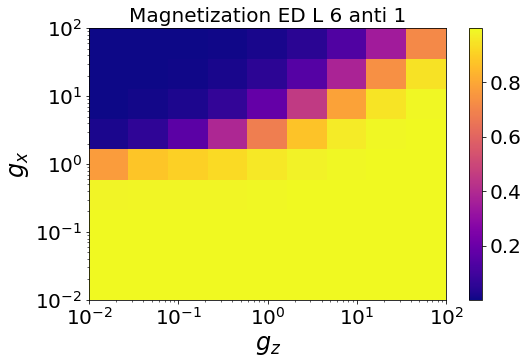

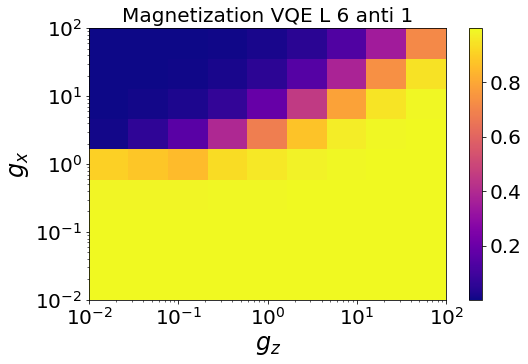

In [11]:
fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, abs(Smags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Magnetization ED L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, abs(Qmags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Magnetization VQE L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

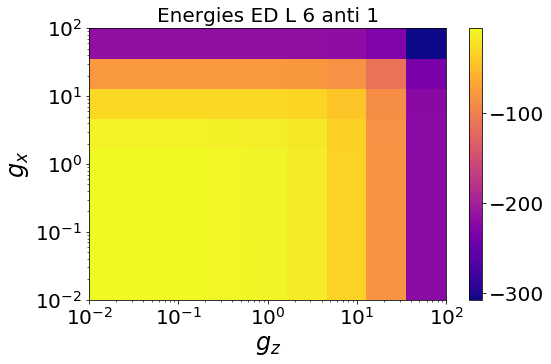

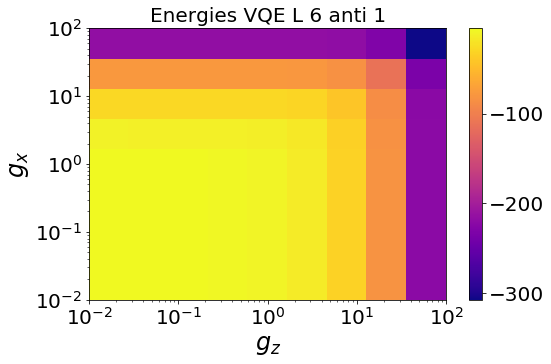

In [12]:
fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, Sen.reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Energies ED L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, Qen.reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Energies VQE L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

# ISING ANTIFERROMAGNETIC

## Obtain the VQE parameters using StatevectorSimulator (NOT NOISY)

In [ ]:
L = 6
anti = -1.

gx_vals = np.logspace(-2,2,10)
gz_vals = np.logspace(-2,2,10)

backend = StatevectorSimulator()
optimizer = SLSQP(maxiter=1000)
ansatz = qiskit.circuit.library.EfficientSU2(L, reps=3)

#backend= AerSimulator() 
#optimizer = SPSA(maxiter=1000)
#ansatz = qiskit.circuit.library.EfficientSU2(L, reps=3)

vqe = VQE(ansatz, optimizer, quantum_instance=backend) 

opt_params = []
gx_list = []
gz_list = []

for i,gx in enumerate(gx_vals):
    for j,gz in enumerate(gz_vals):
    
        print('gx: %.2f, gz: %.2f' %(gx,gz))

        H = QHIsing(L,anti,np.float32(gx),np.float32(gz))
        result = vqe.compute_minimum_eigenvalue(H) #ED with Qiskit VQE
        
        gx_list.append(gx)
        gz_list.append(gz)
        opt_params.append(sort_params(result.optimal_parameters))

        #plt.figure(figsize=(5,5))
        #plt.plot(abs(np.conjugate(result.eigenstate)*result.eigenstate), 'o-')
        #plt.title('gx: %.2f, gz: %.2f' %(gx,gz), fontsize=20)
        #plt.show()

np.savez(f'data/params_VQE_Ising_L%.0f_anti_%.0f.npz' %(L,anti), gx_list=gx_list, gz_list=gz_list, opt_params=opt_params)

## Recover ansatz with optimal parameters and calculate magnetization and energies

In [15]:
L = 6
anti = -1.

gx_vals = np.logspace(-2,2,10)
gz_vals = np.logspace(-2,2,10)

VQE_params = np.load(f'data/params_VQE_Ising_L{L}_anti_%.0f.npz' %anti, allow_pickle=True)
gx_list = VQE_params['gx_list']
gz_list = VQE_params['gz_list']
opt_params = VQE_params['opt_params']

mag = QMag(L,anti) #magnetization operator (Qiskit)
Smag = Mag(L,anti) #magnetization operator (numpy)
# the ~ is the adjoint, but also it turns the is_measurement attribute to True
~StateFn(mag)
# state is technically a circuit, that prepares the ground state via VQE circuit
#state.draw() # uncomment to see, but is very long

Qen=np.zeros(len(opt_params)); Sen=np.zeros(len(opt_params)) #energies
Qmags=np.zeros(len(opt_params)); Smags=np.zeros(len(opt_params)) #magnetizations

In [16]:
for j in range(len(opt_params)):
    
    gx = gx_list[j]
    gz = gz_list[j]
    H = QHIsing(L, anti, np.float32(gx), np.float32(gz)) # build Hamiltonian Op
    state = init_vqe(opt_params[j], L=L)
    StateFn(state)   
    meas_outcome = ~StateFn(mag) @ StateFn(state)
    
    Qmags[j] = meas_outcome.eval()
    e_outcome = ~StateFn(H) @ StateFn(state)
    Qen[j] = e_outcome.eval()

    init_state, E, ham = ising_groundstate(L, anti, np.float(gx), np.float(gz))
    Sen[j] = E
    Smags[j] = init_state.T.conj()@Smag@init_state #Magnetization with Numpy results

/home/joana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
/home/joana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':
/home/joana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


## Figures

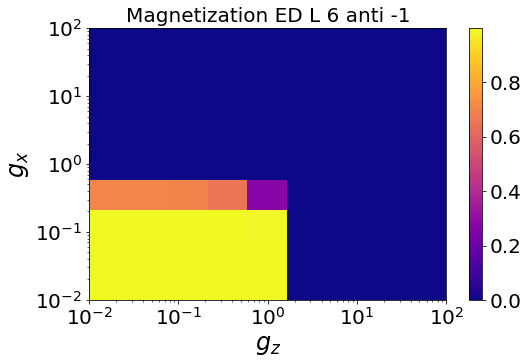

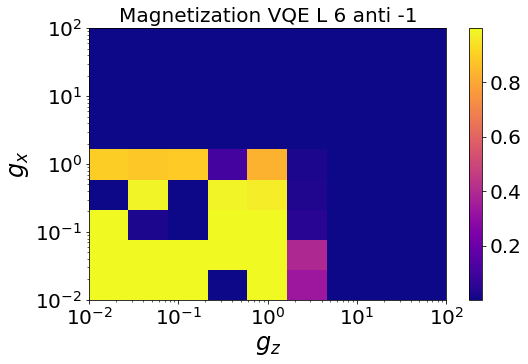

In [17]:
fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, abs(Smags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Magnetization ED L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, abs(Qmags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Magnetization VQE L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

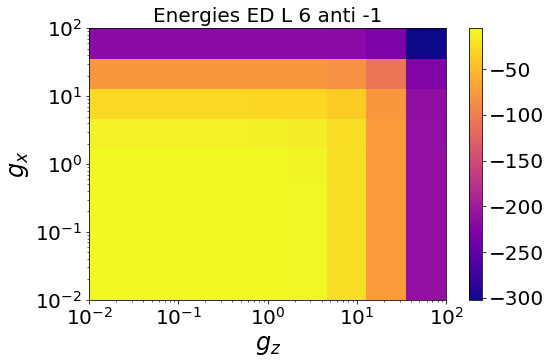

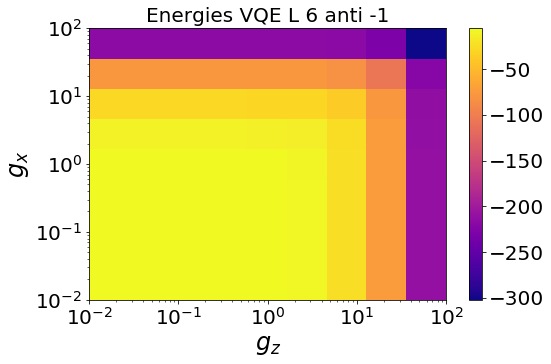

In [18]:
fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, Sen.reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Energies ED L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, Qen.reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Energies VQE L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)